# **Partie 1**

# 1.1 Importations des librairies

In [1]:
#------------------------------------------
# projet 5 : Segmentez des clients d’un site e-commerce
# Auteur : Mohamed MERAH
# Date: Janvier 2024
# OpenClassrooms 2023-2024
#-------------------------------------------

import pandas as pd
import numpy as np
import seaborn as sns
import zipfile
from termcolor import colored
import missingno
import sklearn
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from datetime import timedelta
import datetime
import datetime as dt
from datetime import timedelta
from datetime import datetime
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans 
from sklearn.metrics.cluster import adjusted_rand_score
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# 1.2 Chargement du jeu de données

In [2]:
data_maint= pd.read_csv('C:/Users/misso/Desktop/Formation_DS_23_24_MERAH/2-Projet/5- Projet 5/1-Code/df_rfm_clients.csv').drop(
    ['Unnamed: 0',],axis=1)

# **Partie  2: Simulation**

 - **Ce notebook sera dédié au contrat de maintenance. L'objectif est de faire une recommandation de fréquence à laquelle la segmentation doit être mise à jour pour rester pertinente, afin de pouvoir effectuer un devis de contrat de maintenance. Il s'agit de préciser une période de maintenance au bout de la quelle, l'algorithme doit être ré-étudié vu qu'il commence à perdre ses performances suite aux changements du jeu de données d'entrée.**



# 2.1  Etude de la stabilité temporelle de la segmentation par K-Means


**Contrat de maintenance**

Notre modèle de segmentation choisi, il nous reste à faire une recommandation de fréquence à laquelle cette segmentation doit être mise à jour pour rester pertinente. Elle nous permettra d'établir un contrat de maintenance.

Pour ce faire, nous allons nous baser sur l'Adjusted Rand Index (ARI) qui est l'une des métriques les plus utilisées pour valider les performances de clustering.

L'ARI calcule une mesure de similarité entre deux clusters en considérant toutes les paires d'échantillons et en comptant les paires qui sont assignées dans les mêmes ou différents clusters dans les clusters prédits et réels.

L'ARI doit être interprété comme suit :

    ARI >= 0,90 excellente récupération
    0,80 =< ARI < 0,90 bonne récupération
    0,65 =< ARI < 0,80 récupération modérée
    ARI < 0,65 mauvaise récupération

    Lorsque l'ARI sera < 0.8, la segmentation devra être mise à jour et le modèle réentrainé



# 2.1 Étude de la stabilité des clusters sur les 6 derniers mois

In [3]:
data_maint.columns

Index(['customer_unique_id', 'order_purchase_timestamp', 'Localisation',
       'categorie_produit', 'Log_rfm_Frequency', 'Log_rfm_Monetry',
       'Log_rfm_Recency', 'Log_Satisfaction_score', 'Log_Delai_de_livraison',
       'Log_Nombre_Article'],
      dtype='object')

In [4]:
data_maint = data_maint.drop(["Localisation"], axis=1)
data_maint = data_maint.drop(['categorie_produit'], axis=1)

In [5]:
data_maint

,customer_unique_id,order_purchase_timestamp,Log_rfm_Frequency,Log_rfm_Monetry,Log_rfm_Recency,Log_Satisfaction_score,Log_Delai_de_livraison,Log_Nombre_Article
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,0.693147,4.962145,4.718499,1.791759,1.945910,0.693147
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,0.693147,3.338967,4.744932,1.609438,1.386294,0.693147
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,0.693147,4.468434,6.285998,1.386294,3.258097,0.693147
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,0.693147,3.798182,5.771441,1.609438,3.044522,0.693147
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,0.693147,5.287711,5.662960,1.791759,2.639057,0.693147
...,...,...,...,...,...,...,...,...
88882,fffb09418989a0dbff854a28163e47c6,2017-12-17 19:14:35,0.693147,4.306225,5.541264,1.791759,2.197225,0.693147
88883,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,0.693147,4.449452,5.568345,1.609438,3.433987,0.693147
88884,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,0.693147,4.731450,6.342121,1.791759,2.708050,0.693147
88885,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,0.693147,4.902976,4.779123,1.791759,2.484907,0.693147


In [6]:
# Nombre de données dupliquées 
def Nb_Data_Dupliq(data) :
    return print("Nombre de données dupliquées :",data.duplicated().sum())

In [7]:
#Nb_Data_Dupliq(data_maint)

In [8]:
# Suppression des doublons
data_maint.drop_duplicates(subset=['customer_unique_id'],
                    inplace=True)

In [9]:
#Nombre Ligne et Colonne
data_maint.shape

(86766, 8)

In [10]:
data_maint['order_purchase_timestamp'] = data_maint[
    'order_purchase_timestamp'].apply(
     lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

In [11]:
data_maint = data_maint.set_index('customer_unique_id')

In [12]:
colonnes = data_maint.columns.to_list()
colonnes.remove('order_purchase_timestamp')

In [13]:
#Date Debut & Date Fin
debut_periode, fin_periode = data_maint['order_purchase_timestamp'].min(),\
                             data_maint['order_purchase_timestamp'].max()

In [14]:
debut_periode, fin_periode

(Timestamp('2016-10-05 12:32:55'), Timestamp('2018-08-21 14:57:19'))

In [15]:
date_T0_sem = pd.date_range(debut_periode, fin_periode, freq="w")[70]
date_T0_TN_sem = pd.date_range(debut_periode, fin_periode, freq="w")[71:]

 **On va étudier la stabilité des clusters sur les 5 derniers mois**

In [16]:
date_T0_sem

Timestamp('2018-02-11 12:32:55')

In [17]:
date_T0_TN_sem

DatetimeIndex(['2018-02-18 12:32:55', '2018-02-25 12:32:55',
               '2018-03-04 12:32:55', '2018-03-11 12:32:55',
               '2018-03-18 12:32:55', '2018-03-25 12:32:55',
               '2018-04-01 12:32:55', '2018-04-08 12:32:55',
               '2018-04-15 12:32:55', '2018-04-22 12:32:55',
               '2018-04-29 12:32:55', '2018-05-06 12:32:55',
               '2018-05-13 12:32:55', '2018-05-20 12:32:55',
               '2018-05-27 12:32:55', '2018-06-03 12:32:55',
               '2018-06-10 12:32:55', '2018-06-17 12:32:55',
               '2018-06-24 12:32:55', '2018-07-01 12:32:55',
               '2018-07-08 12:32:55', '2018-07-15 12:32:55',
               '2018-07-22 12:32:55', '2018-07-29 12:32:55',
               '2018-08-05 12:32:55', '2018-08-12 12:32:55',
               '2018-08-19 12:32:55'],
              dtype='datetime64[ns]', freq='W-SUN')

In [18]:
data_F0 = data_maint[(data_maint['order_purchase_timestamp'] < date_T0_sem)]
data_F0 = data_F0[colonnes].copy()

In [19]:
model_M0 = KMeans(n_clusters=5, init='k-means++',
                  max_iter=200, random_state=42)
scaler_T0 = StandardScaler()
data_F0 = scaler_T0.fit_transform(data_F0)
model_M0.fit(data_F0)

KMeans(max_iter=200, n_clusters=5, random_state=42)

In [20]:
ARI_score_sem = []
sem = 0
for date_TI in date_T0_TN_sem:
    data_TI = data_maint[(data_maint['order_purchase_timestamp'] < date_TI)]
    data_TI = data_TI[colonnes].copy()
    sem += 1
    print('nombre de client :', len(data_TI), 'pour la date :',
          date_TI, ' ( T', sem, ')')
    scaler_TI = StandardScaler()
    data_TI_scaled = scaler_TI.fit_transform(data_TI)
    model_MI = KMeans(n_clusters=5, init='k-means++',
                      max_iter=200, random_state=42)
    model_MI.fit(data_TI_scaled)
    ARI_score_sem.append(
        adjusted_rand_score(
            model_MI.predict(data_TI_scaled),
            model_M0.predict(scaler_T0.transform(data_TI))
        )
    )

nombre de client : 48744 pour la date : 2018-02-18 12:32:55  ( T 1 )
nombre de client : 50247 pour la date : 2018-02-25 12:32:55  ( T 2 )
nombre de client : 51851 pour la date : 2018-03-04 12:32:55  ( T 3 )
nombre de client : 53294 pour la date : 2018-03-11 12:32:55  ( T 4 )
nombre de client : 54700 pour la date : 2018-03-18 12:32:55  ( T 5 )
nombre de client : 56245 pour la date : 2018-03-25 12:32:55  ( T 6 )
nombre de client : 57538 pour la date : 2018-04-01 12:32:55  ( T 7 )
nombre de client : 58975 pour la date : 2018-04-08 12:32:55  ( T 8 )
nombre de client : 60327 pour la date : 2018-04-15 12:32:55  ( T 9 )
nombre de client : 61869 pour la date : 2018-04-22 12:32:55  ( T 10 )
nombre de client : 63432 pour la date : 2018-04-29 12:32:55  ( T 11 )
nombre de client : 65024 pour la date : 2018-05-06 12:32:55  ( T 12 )
nombre de client : 66824 pour la date : 2018-05-13 12:32:55  ( T 13 )
nombre de client : 68546 pour la date : 2018-05-20 12:32:55  ( T 14 )
nombre de client : 69455 pour

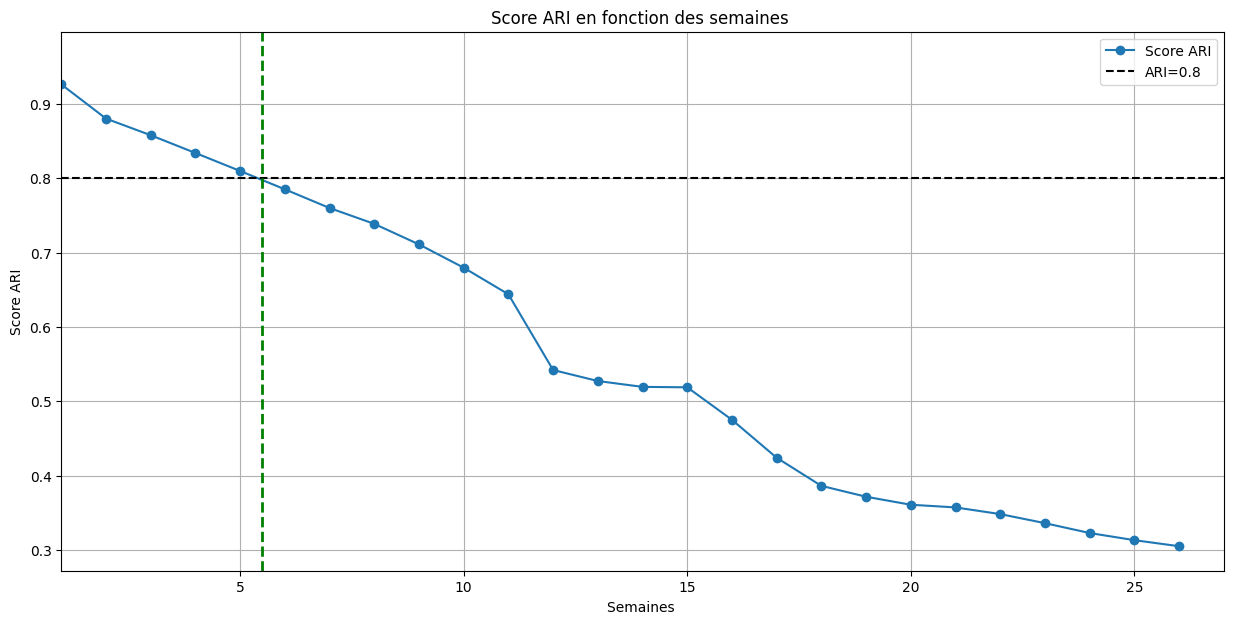

In [21]:
df_ARI = pd.DataFrame({"Semaine": range(0, len(ARI_score_sem)),
                      "Score_ARI": ARI_score_sem})
plt.figure(figsize=(15, 7))

# Drawing ARI Score
plt.plot(
    "Semaine",
    "Score_ARI",
    data=df_ARI,
    linestyle="-",
    marker="o",
    label="Score ARI",
)

# Drawing a horizontal line at point seuil
plt.axhline(
    y=0.8,
    linestyle="--",
    color="black",
    label="ARI=0.8",)

# Drawing a vertical line at the intersection
plt.axvline(x=5.5, linestyle="--", 
            color="green",
            ymax=1.48,
            linewidth=2)

plt.grid()
plt.xlim(1, len(ARI_score_sem))
plt.xlabel("Semaines ")
plt.ylabel("Score ARI")
plt.legend()
plt.title("Score ARI en fonction des semaines ")
plt.show()

 - **Au bout de 5 semaines et demi, le score ARI est inférieur à 0.8. Il faut faire une mise à jour des clients tous les 5 semaines et demi (38 jours)**

# 2.2 Étude de la stabilité des clusters sur les 12 derniers mois

In [22]:
date_T0_mois = pd.date_range(debut_periode, fin_periode, freq="M")[8]
date_T0_TN_mois = pd.date_range(debut_periode, fin_periode, freq="M")[9:]

In [23]:
date_T0_mois

Timestamp('2017-06-30 12:32:55')

In [24]:
date_T0_TN_mois

DatetimeIndex(['2017-07-31 12:32:55', '2017-08-31 12:32:55',
               '2017-09-30 12:32:55', '2017-10-31 12:32:55',
               '2017-11-30 12:32:55', '2017-12-31 12:32:55',
               '2018-01-31 12:32:55', '2018-02-28 12:32:55',
               '2018-03-31 12:32:55', '2018-04-30 12:32:55',
               '2018-05-31 12:32:55', '2018-06-30 12:32:55',
               '2018-07-31 12:32:55'],
              dtype='datetime64[ns]', freq='M')

In [25]:
data_F0_mois = data_maint[(data_maint['order_purchase_timestamp']
                           < date_T0_mois)]
data_F0_mois = data_F0_mois[colonnes].copy()

In [26]:
model_M0 = KMeans(n_clusters=5, init='k-means++',
                  max_iter=300, random_state=42)
scaler_T0 = StandardScaler()
data_F0_mois = scaler_T0.fit_transform(data_F0_mois)
model_M0.fit(data_F0_mois)

KMeans(n_clusters=5, random_state=42)

In [27]:
ARI_score_mois = []
mois = 0
for date_TI in date_T0_TN_mois:
    data_TI = data_maint[(data_maint['order_purchase_timestamp'] < date_TI)]
    data_TI = data_TI[colonnes].copy()
    mois += 1
    print('nombre de client :', len(data_TI), 'pour la date :',
          date_TI, ' ( T', mois, ')')
    scaler_TI = StandardScaler()
    data_TI_scaled = scaler_TI.fit_transform(data_TI)
    model_MI = KMeans(n_clusters=5, init='k-means++',
                      max_iter=300, random_state=42)
    model_MI.fit(data_TI_scaled)
    ARI_score_mois.append(
        adjusted_rand_score(
            model_MI.predict(data_TI_scaled),
            model_M0.predict(scaler_T0.transform(data_TI))
        )
    )

nombre de client : 15443 pour la date : 2017-07-31 12:32:55  ( T 1 )
nombre de client : 19296 pour la date : 2017-08-31 12:32:55  ( T 2 )
nombre de client : 23115 pour la date : 2017-09-30 12:32:55  ( T 3 )
nombre de client : 27213 pour la date : 2017-10-31 12:32:55  ( T 4 )
nombre de client : 33776 pour la date : 2017-11-30 12:32:55  ( T 5 )
nombre de client : 38911 pour la date : 2017-12-31 12:32:55  ( T 6 )
nombre de client : 45162 pour la date : 2018-01-31 12:32:55  ( T 7 )
nombre de client : 50969 pour la date : 2018-02-28 12:32:55  ( T 8 )
nombre de client : 57394 pour la date : 2018-03-31 12:32:55  ( T 9 )
nombre de client : 63635 pour la date : 2018-04-30 12:32:55  ( T 10 )
nombre de client : 69956 pour la date : 2018-05-31 12:32:55  ( T 11 )
nombre de client : 75663 pour la date : 2018-06-30 12:32:55  ( T 12 )
nombre de client : 81285 pour la date : 2018-07-31 12:32:55  ( T 13 )


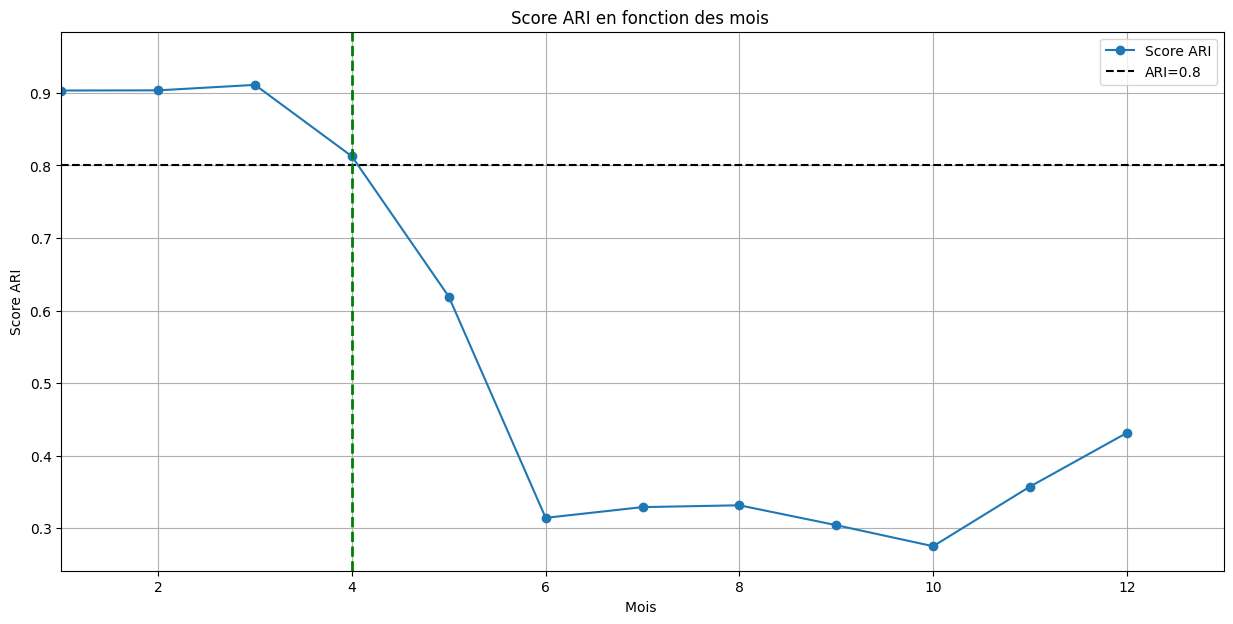

In [28]:
df_ARI_mois = pd.DataFrame({"Mois": range(0, len(ARI_score_mois)),
                           "Score_ARI": ARI_score_mois})
plt.figure(figsize=(15, 7))
plt.plot(
    "Mois",
    "Score_ARI",
    data=df_ARI_mois,
    linestyle="-",
    marker="o",
    label="Score ARI",
)
plt.axhline(
    y=0.8,
    linestyle="--",
    color="black",
    label="ARI=0.8")
    
plt.axvline(x=4, linestyle="--", 
            color="green",
            ymax=1.48,
            linewidth=2)

plt.grid()
plt.xlim(1, len(ARI_score_mois))
plt.xlabel("Mois ")
plt.ylabel("Score ARI")
plt.legend()
plt.title("Score ARI en fonction des mois ")
plt.show()

 - **Au bout de 4 mois , le score ARI est inférieur à 0.8. Il faut faire une mise à jour des clients tous les 4 mois**

- **Le modèle devra être réentrainé tous les 4 mois. Nous pouvons donc établir un devis pour un contrat de maintenance qui intégrerait une mise à jour de la segmentation tous les 4 mois**